# Определение ориентации справки

## Описание проекта

Необходимо разработать модель определения ориентации справки и автоматического поворота её в нормальное положение перед запуском сервиса OCR. Это необходимо для заказчика DonorSearch, чтобы качественно распознавать данные из изображения 405 справки. Исходный датасет представляет собой неразмеченные изображения 405 справки и не только, название каждого файла начинается с 3 цифр, которые обозначают форму документа. Все исходные изображения помещены в папку raw_images

## Исследовательский анализ данных

In [1]:
IS_COLAB = True #индикатор работы в колабе для подключения Google.Диск
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/DonorSearch"
    %pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DonorSearch


In [2]:
import os
from pathlib import Path
from time import time

import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import notebook
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision.transforms.functional import to_pil_image, InterpolationMode, rotate, resize
import matplotlib.pyplot as plt

In [3]:
#Константы
RANDOM_STATE = 20240920
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Создадим функцию для извлечения основных параметров из изображения. Так как изображение может быть повёрнуто, то выделим минимальный размер, максимальный размер и отношение минимального размера к максимальному.

In [4]:
def get_img_info(path:Path, filter_name='*'):
    from PIL import Image
    img_info = {key:[] for key in ('path', 'mode', 'palette', 'min_size', 'max_size', 'ratio')}
    for p in path.glob(filter_name):
        img = Image.open(p)
        img_info['path'].append(str(p))
        img_info['mode'].append(img.mode)
        img_info['palette'].append(img.palette.mode if img.palette else None)
        sz = img.size
        img_info['min_size'].append(min(sz))
        img_info['max_size'].append(max(sz))
        img_info['ratio'].append(min(sz)/max(sz))
    return pd.DataFrame(img_info)
imgs = get_img_info(Path("raw_images"), "*")
imgs.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   path      173 non-null    object 
 1   mode      173 non-null    object 
 2   palette   170 non-null    object 
 3   min_size  173 non-null    int64  
 4   max_size  173 non-null    int64  
 5   ratio     173 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 8.2+ KB


In [5]:
imgs.nunique()

,0
path,173
mode,2
palette,1
min_size,71
max_size,53
ratio,70


Видно, что есть два типа файлов, выведем их типы

In [6]:
imgs['mode'].value_counts()

,count
mode,
P,170
L,3


In [7]:
imgs.describe()

,min_size,max_size,ratio
count,173.000000,173.000000,173.000000
mean,581.109827,911.664740,0.601328
std,472.475070,610.968544,0.135096
min,216.000000,359.000000,0.352000
25%,231.000000,500.000000,0.462000
50%,375.000000,500.000000,0.564000
75%,600.000000,1169.000000,0.750000
max,1893.000000,2764.000000,0.906552


Выведем отдельно информацию по изображениям 405 справок

In [8]:
imgs[imgs.path.str.contains(r"\\405__")].describe()

,min_size,max_size,ratio
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


Выведем 8 случайных изображений 405 справки

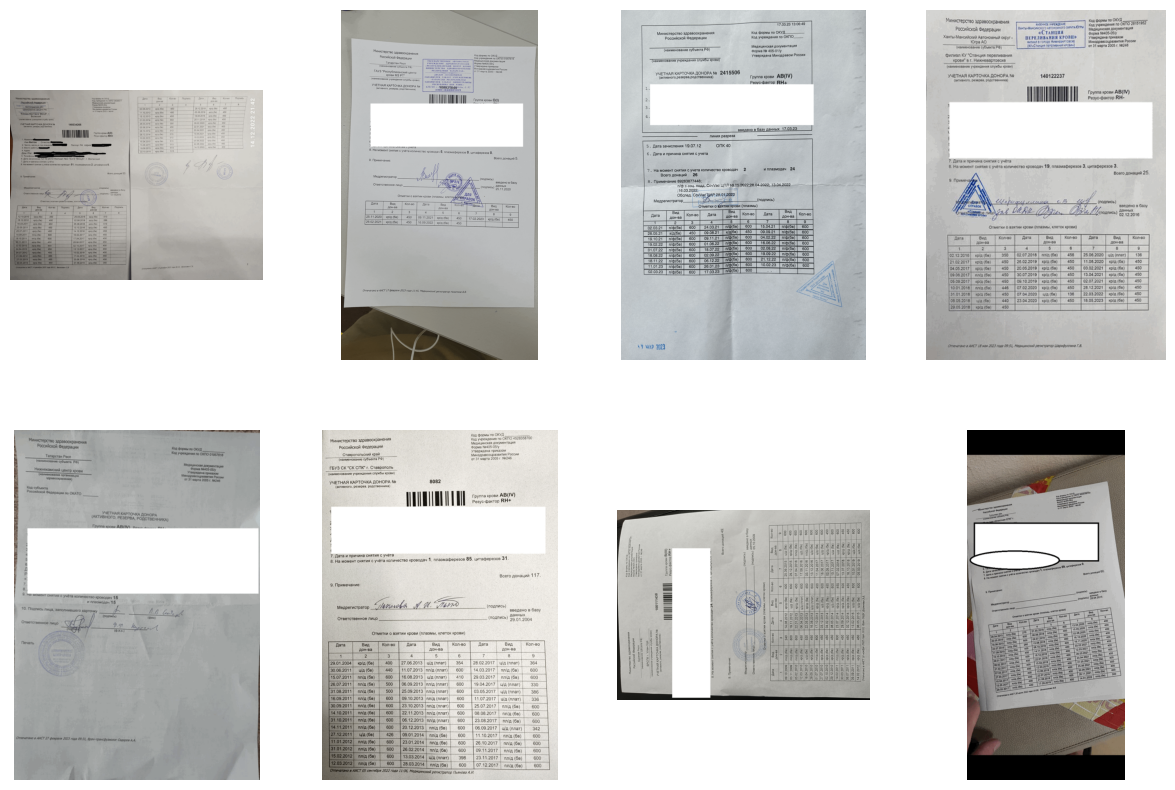

In [9]:
plt.figure(figsize=(15, 10))
for idx, path in enumerate(imgs.loc[imgs.path.str.contains('405__'),'path'].sample(8, random_state=RANDOM_STATE),1):
    plt.subplot(2,4,idx)
    plt.axis("off")
    plt.imshow(Image.open(path))

**Выводы:**
1. в исходном датасете 173 изображения, из которых только 48 - это справки 405 формы, поэтому датасет необходимо увеличить;
2. встречаются два типа изображения: P и L, т.е. одноканальные;
3. соотношение сторон минимальной к максимальной меняется от 0,35 до 0,91 для всех изображений и от 0,45 до 0,90 для 405 справки;
4. медиана коэффициента соотношения сторон равна 0,56 для всех изображений, что близко к широкоформатному формату 16:9, а для 405 справок - 0,75 (или формат 4:3);
5. Основная часть 405 справок не нужно поворачивать.

## Исследование существующих подходов к решению задачи

Для определения угла поворота текста есть ряд подходов:
1. на основе детекции углов текста (https://arxiv.org/pdf/1802.08948v2);
2. на основе семантической сегментации (https://arxiv.org/pdf/1802.08948v2);
3. на основе быстрого преобразования Фурье (https://www.kaggle.com/code/alibalapour/rotation-prediction-de-skewing-text-in-images#Sample);
4. прохождением RPN по предпоследнему слою предобученной сети (https://arxiv.org/pdf/1703.01086v3);
5. непосредственно fine-tuning или transfer learning предобученной сети.

Определение угла поворота текста на основе детекции углов текста позволяет достаточно точно определить угол поворота текста, если ошибка определния коородинат углов будет достаточно небольшой. Подход на основе семантической сегментации близок к первому методу, только для дальнейшего постпроцессинга используется вся область текста. Применительно к нашей задаче 1 и 2 эти пути сложны в реализации, так как потребует дополнительного времени на разметку данных.

3 вариант решения представляет собой нейронную сеть, которой на вход подаётся обработанное изображение с использованием FFT. Этот метод достаточно хорошо позволяет определить ориентацию +- 90 градусов, но при повороте изображения на 180 градусов или 270 будут ошибки.

RPN представляет из себя дополнительную нейронную сеть, которая генерирует шаблоны возможного нахождения текста. Затем эти шаблоны накладываются на Feature Map (полученные из основной нейронной модели) и проводится анализ слоем ROI.

Учитывая, что в 405 справках есть не только текст, но и таблицы, к тому же не стоит задача находить точный угол поворота, то даже 5 подход будет давать неплохой результат, главное преимущество которого - в относительной простоте реализации.

## Подготовка к обучению

### Аугментация изображений поворотом

Учитывая, что справок 405 формы мало, то необходимо увеличить датасет. Одним из способов является поворот каждого изображения на все 4 угла. Для этого создадим класс Classificator. Угол поворота в 0 градусов обозначим меткой 0, 90 градусов - 1 и т.д.

In [10]:
class Classificator:
    def __init__ (self, path, new_dir:Path, path_labels):
        self.path=path
        self.img=read_image(self.path,
                            mode=ImageReadMode.RGB
                           )
        self.new_dir = new_dir
        self.path_labels = path_labels
        self.start_label=None

    def show(self):
        #показать исходное изображение справки
        print(f"{self.path}-->{self.img.shape}")
        plt.figure(figsize=(10,10))
        plt.imshow(to_pil_image(resize(self.img, 800)))

    def add_labels(self, start_label):
        #добавить метку исходного изображения, а также 3ёх повёрнутых
        self.start_label = start_label
        try:
            df = pd.read_csv(self.path_labels)
        except:
            df = pd.DataFrame(columns=['name','label'])
        imgs = []
        for i in range(4): #поворачиваем изображение и присваиваем соответсвующую метку
            idx = (self.start_label+i)%4
            new_img = rotate(
                self.img,
                angle=90*i,
                interpolation=InterpolationMode.BILINEAR,
                expand=True
            )
            img_name = f"{self.path.stem}_{idx}{self.path.suffix}" #добавление индекса к исходному названию файла
            to_pil_image(new_img).save(self.new_dir.joinpath(img_name)) #сохраним изображение в папку new_dir
            imgs.append([img_name, idx])

        df = pd.concat([df, pd.DataFrame(imgs, columns=['name','label'])])
        df.to_csv(self.path_labels, index=None) #добавление информации о метке в файл path_labels

Учитывая, что при обучении важно, чтобы модель распознавала ориентацию букв, то аугментируем не только 405 справки, но и остальные изображения

In [11]:
#выведем количество изображений данного типа
NUM_DOC=448 #номер документа
list_imgs = list(Path("raw_images/").glob(f'{NUM_DOC}*'))
len(list_imgs)

41

raw_images/448___7570f37b00304f1cac7bb08cc045eb15.png-->torch.Size([3, 2000, 1500])


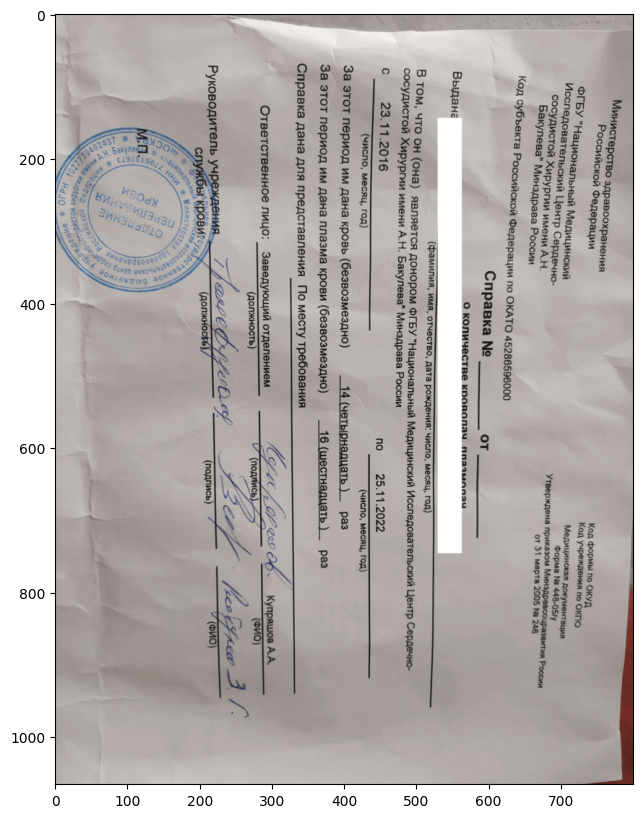

In [12]:
#покажем исходное изображение с порядковым номером idx_img
idx_img = 5
cls_img = Classificator(list_imgs[idx_img],
                        Path("dataset/images/"),
                        Path(f"dataset/labels/{NUM_DOC}.csv"))
cls_img.show()

In [13]:
#cls_img.add_labels(0) #добавление метки в "dataset/labels/{NUM_DOC}.csv"

Выведем общее количество файлов в папке images

In [14]:
len(list(Path("dataset/images/").glob(f'*')))

692

Таким образом количество изображений увеличилось в 4 раза, к тому же классы стали сбалансированными

### Функция генерации датасетов

Создадим класс Documents на основе Dataset, добавим туда возможность выбирать часть изображений по индексам.

In [15]:
class Documents(Dataset):
    def __init__(self, annotations_file, *, img_dir, indexes:list=None, transforms=None, target_transforms=None):
        all_labels = pd.read_csv(annotations_file)
        if indexes:
            img_labels = all_labels.loc[indexes].reset_index(drop=True)
        else:
            img_labels = all_labels
        self.img_labels = dict()
        for idx, row in img_labels.iterrows():
            self.img_labels[idx] = row
        self.img_dir = img_dir
        self.transforms = transforms
        self.target_transforms = target_transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        name, label = self.img_labels.get(idx)
        img_path = os.path.join(self.img_dir, name)
        image = read_image(img_path, mode=ImageReadMode.RGB).to(device)

        if self.transforms:
            image = self.transforms(image)
        else:
            image = transforms.functional.to_tensor(image)
        if self.target_transforms:
            label = self.target_transforms(label)
        return image, label

Создадим функцию для генерации датасетов по трансформациям, которые необходимо сделать над изображениями. Чтобы не происходило утечки данных, в одну выборку попадают все 4 повёрнутых изображения.

In [16]:
def gen_datasets(train_tfmr, val_tfmr, test_tfmr):
    #405 справки делим примерно на 3 равные части, остальные изображения добавляем в обучающую выборку
    transformers = dict(zip(['train','val','test'], [train_tfmr, val_tfmr, test_tfmr]))
    list_files = list(Path("dataset/images").glob('405*')) #список названий файлов 405 справок
    indexes_405 = {}
    indexes_405['train'],  indexes_405['val'],  indexes_405['test'] = random_split(range(len(list_files)//4),
                                                                                    [0.3, 0.3, 0.4], #на тест чуть побольше изображений
                                                                                    torch.Generator().manual_seed(RANDOM_STATE))
    dataset_405 = {}
    for key, idx in indexes_405.items():
        dataset_405[key] = Documents("dataset/labels/405.csv",
                                      img_dir="dataset/images",
                                      indexes=[4*i+j for i in idx for j in range(4)], #в одну выборку попадают все 4 повёрнутых изображения
                                      transforms=transformers[key])
    train_dataset = [dataset_405.get('train')]

    for doc_type in ('402', '406', '444', '448'):
        train_dataset.append(
            Documents(f"dataset/labels/{doc_type}.csv",
                        img_dir="dataset/images",
                        transforms=transformers['train'])
        )
    return ConcatDataset(train_dataset), dataset_405['val'], dataset_405['test']

### Функции для обучения, валидации и предсказания модели

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    #обучение на каждой эпохе
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    time_inference = 0

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        time1 = time()
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(preds == labels).item()
        processed_size += batch_size
        time2 = time()
        time_inference+=time2-time1

    scheduler.step()
    train_loss = running_loss / processed_size
    train_acc = running_corrects / processed_size
    return train_loss, train_acc, time_inference

In [18]:
def eval_epoch(model, val_loader, criterion):
    #валидация на каждой эпохе
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    with torch.set_grad_enabled(False):
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels).item()
            processed_size += batch_size
        val_loss = running_loss / processed_size
        val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [19]:
def predict(model, test_loader):
    #предсказания
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            predicts = torch.argmax(outputs, 1)
            preds.append(predicts.cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(predicts == labels).item()
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects / processed_size
    return answers, preds, probs, test_acc

In [20]:
def train(train, val, model, epochs, criterion, opt, sch):

    history = []
    best_model = {'loss': None, 'model': None, 'epoch':None}

    epochs_iter = notebook.tqdm(range(epochs), colour='green',
                                bar_format='{l_bar} {bar} | Осталось {remaining} | Прошло {elapsed}')
    for epoch in epochs_iter:
        train_loss, train_acc, time_inference = fit_epoch(model, train, criterion, opt, sch)
        val_loss, val_acc = eval_epoch(model, val, criterion)
        best_loss = best_model.get('loss')
        if not best_loss or best_loss>val_loss:
            best_model['loss']=val_loss
            best_model['model']=model.state_dict()
            best_model['epoch']=epoch
            epochs_iter.set_description(
                desc=f"Поиск...{train_loss=:.4f}, {train_acc=:.4f}, "
                     f"{val_loss=:.4f}, {val_acc=:.4f}, "
                     f"avg_time={time_inference/(epoch+1):.4f} с")
        history.append((train_loss, train_acc, val_loss, val_acc))
    return history

In [21]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(model)
    plt.show()

## Обучение моделей

Для датасета будем использовать случайные трансформации поворота на угол и перспективы. Учитывая, что некоторые справки уже повёрнуты на какой-то угол, то ограничимся 5 градусами, чтобы гарантировано не повернуть изображение на угол 45 градусов. Искажения от перспективы тоже нужно ограничить в силу небольшого разрешения основной массы изображений.

Последние 3 слоя в каждой модели будем размораживать. В качестве первых моделей выберем модели ResNet. Также проанализируем другие более лёгкие модели с хорошими результатами при тестировании на датасете ImageNet.

### ResNet18

In [22]:
train_transformer = transforms.Compose([
    transforms.RandomAffine(degrees=5),
    transforms.RandomPerspective(distortion_scale=0.1),
    models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    ])

val_transformer = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

test_transformer = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

In [23]:
train_dataset, val_dataset, test_dataset = gen_datasets(train_transformer, val_transformer, test_transformer)
len(train_dataset), len(val_dataset), len(test_dataset)

(560, 56, 76)

In [24]:
gen = torch.Generator().manual_seed(RANDOM_STATE)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, drop_last=True, generator=gen)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [25]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
layers = list(resnet18.children())
sz = len(layers)
for idx, layer in enumerate(layers,1):
    for param in layer.parameters():
        param.requires_grad = idx>sz-3
layers[-1].out_features=4

resnet18 = resnet18.to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
history = train(train_dataloader, val_dataloader, model=resnet18, epochs=10,
                criterion=nn.CrossEntropyLoss(), opt=optimizer, sch=scheduler)

  0%|            | Осталось ? | Прошло 00:00

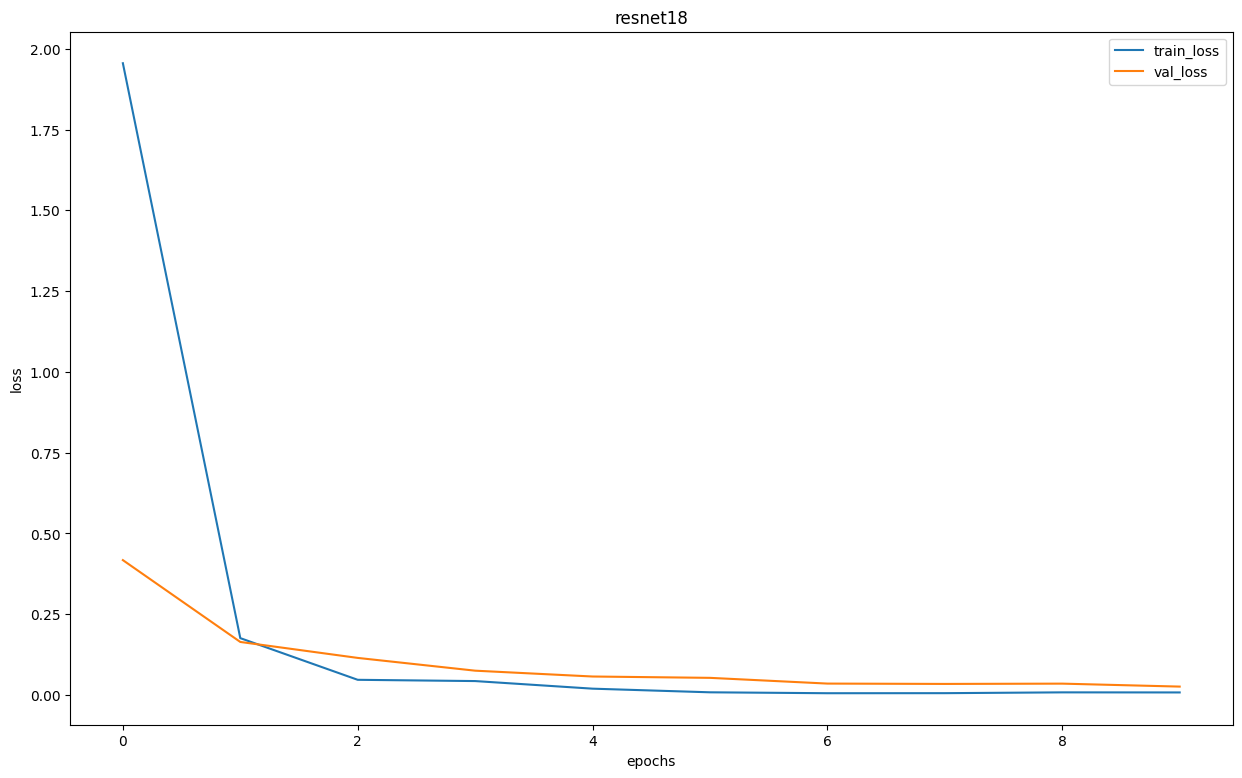

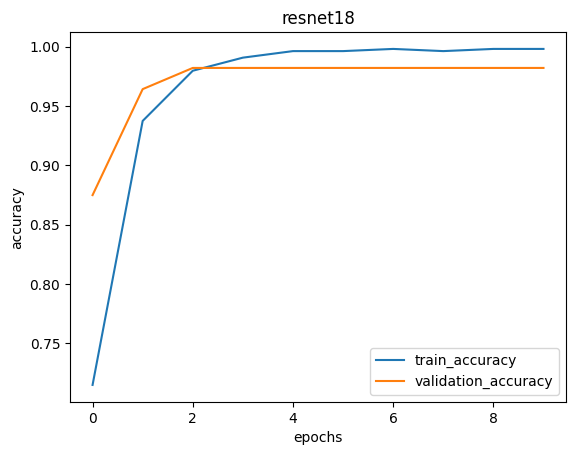

In [26]:
vizualize(history, 'resnet18')

### Resnet34

In [27]:
train_transformer = transforms.Compose([
    transforms.RandomAffine(degrees=5),
    transforms.RandomPerspective(distortion_scale=0.1),
    models.ResNet34_Weights.IMAGENET1K_V1.transforms()
    ])

val_transformer = models.ResNet34_Weights.IMAGENET1K_V1.transforms()

test_transformer = models.ResNet34_Weights.IMAGENET1K_V1.transforms()

In [28]:
train_dataset, val_dataset, test_dataset = gen_datasets(train_transformer, val_transformer, test_transformer)
len(train_dataset), len(val_dataset), len(test_dataset)

(560, 56, 76)

In [29]:
gen = torch.Generator().manual_seed(RANDOM_STATE)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, drop_last=True, generator=gen)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [30]:
resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
layers = list(resnet34.children())
sz = len(layers)
for idx, layer in enumerate(layers,1):
    for param in layer.parameters():
        param.requires_grad = idx>sz-3
layers[-1].out_features=4

resnet34 = resnet34.to(device)
optimizer = torch.optim.Adam(resnet34.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
history = train(train_dataloader, val_dataloader, model=resnet34, epochs=10,
                criterion=nn.CrossEntropyLoss(), opt=optimizer, sch=scheduler)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 179MB/s]


  0%|            | Осталось ? | Прошло 00:00

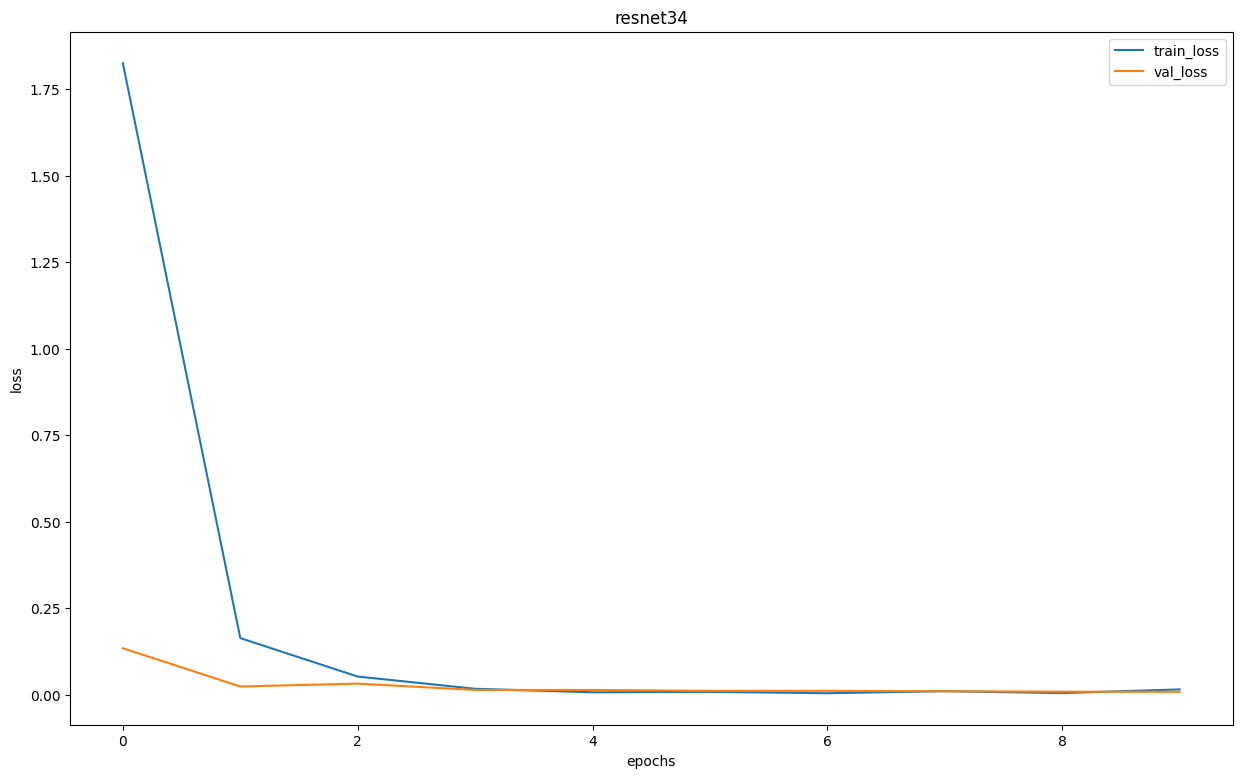

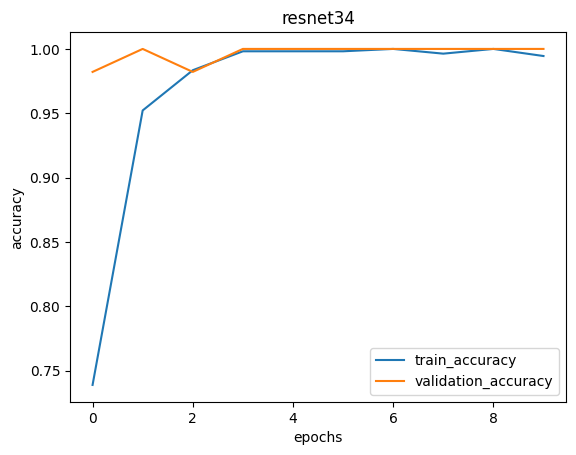

In [31]:
vizualize(history, 'resnet34')

### MobileNet V3

In [32]:
train_transformer = transforms.Compose([
    transforms.RandomAffine(degrees=5),
    transforms.RandomPerspective(distortion_scale=0.1),
    models.MobileNet_V3_Large_Weights.IMAGENET1K_V2.transforms()
    ])

val_transformer = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2.transforms()

test_transformer = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2.transforms()

In [33]:
train_dataset, val_dataset, test_dataset = gen_datasets(train_transformer, val_transformer, test_transformer)
len(train_dataset), len(val_dataset), len(test_dataset)

(560, 56, 76)

In [34]:
gen = torch.Generator().manual_seed(RANDOM_STATE)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, drop_last=True, generator=gen)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [35]:
mobilenet_v3 = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)
layers = list(mobilenet_v3.children())
sz = len(layers)
for idx, layer in enumerate(layers,1):
    for param in layer.parameters():
        param.requires_grad = idx>sz-3
layers[-1].out_features=4

mobilenet_v3 = mobilenet_v3.to(device)
optimizer = torch.optim.Adam(mobilenet_v3.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
history = train(train_dataloader, val_dataloader, model=mobilenet_v3, epochs=10,
                criterion=nn.CrossEntropyLoss(), opt=optimizer, sch=scheduler)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 121MB/s] 


  0%|            | Осталось ? | Прошло 00:00

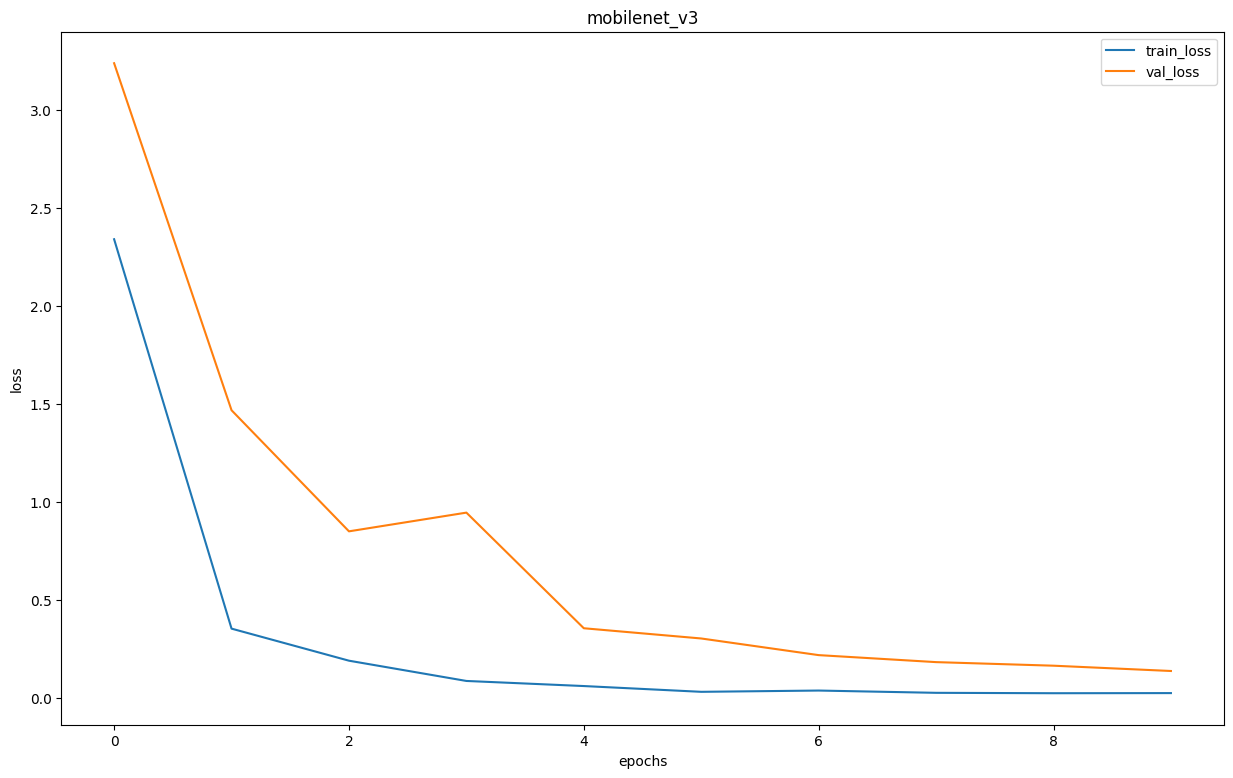

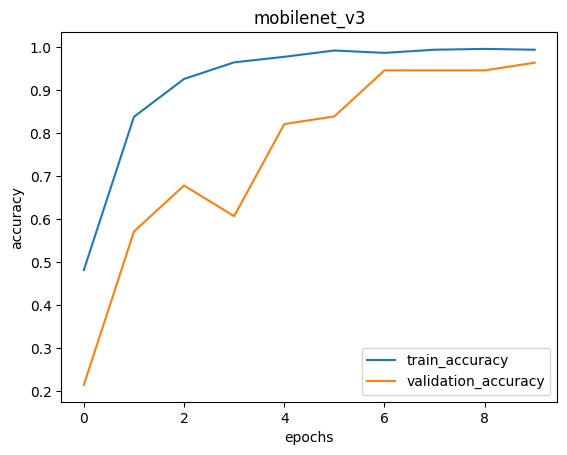

In [36]:
vizualize(history, 'mobilenet_v3')

### ShuffleNet V2

In [37]:
train_transformer = transforms.Compose([
    transforms.RandomAffine(degrees=5),
    transforms.RandomPerspective(distortion_scale=0.1),
    models.ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1.transforms()
    ])

val_transformer = models.ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1.transforms()

test_transformer = models.ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1.transforms()

In [38]:
train_dataset, val_dataset, test_dataset = gen_datasets(train_transformer, val_transformer, test_transformer)
len(train_dataset), len(val_dataset), len(test_dataset)

(560, 56, 76)

In [39]:
gen = torch.Generator().manual_seed(RANDOM_STATE)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, drop_last=True, generator=gen)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [40]:
shufflenet_v2 = models.shufflenet_v2_x2_0(weights=models.ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1)
layers = list(shufflenet_v2.children())
sz = len(layers)
for idx, layer in enumerate(layers,1):
    for param in layer.parameters():
        param.requires_grad = idx>sz-3
layers[-1].out_features=4

shufflenet_v2 = shufflenet_v2.to(device)
optimizer = torch.optim.Adam(shufflenet_v2.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
history = train(train_dataloader, val_dataloader, model=shufflenet_v2, epochs=10,
                criterion=nn.CrossEntropyLoss(), opt=optimizer, sch=scheduler)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:00<00:00, 77.1MB/s]


  0%|            | Осталось ? | Прошло 00:00

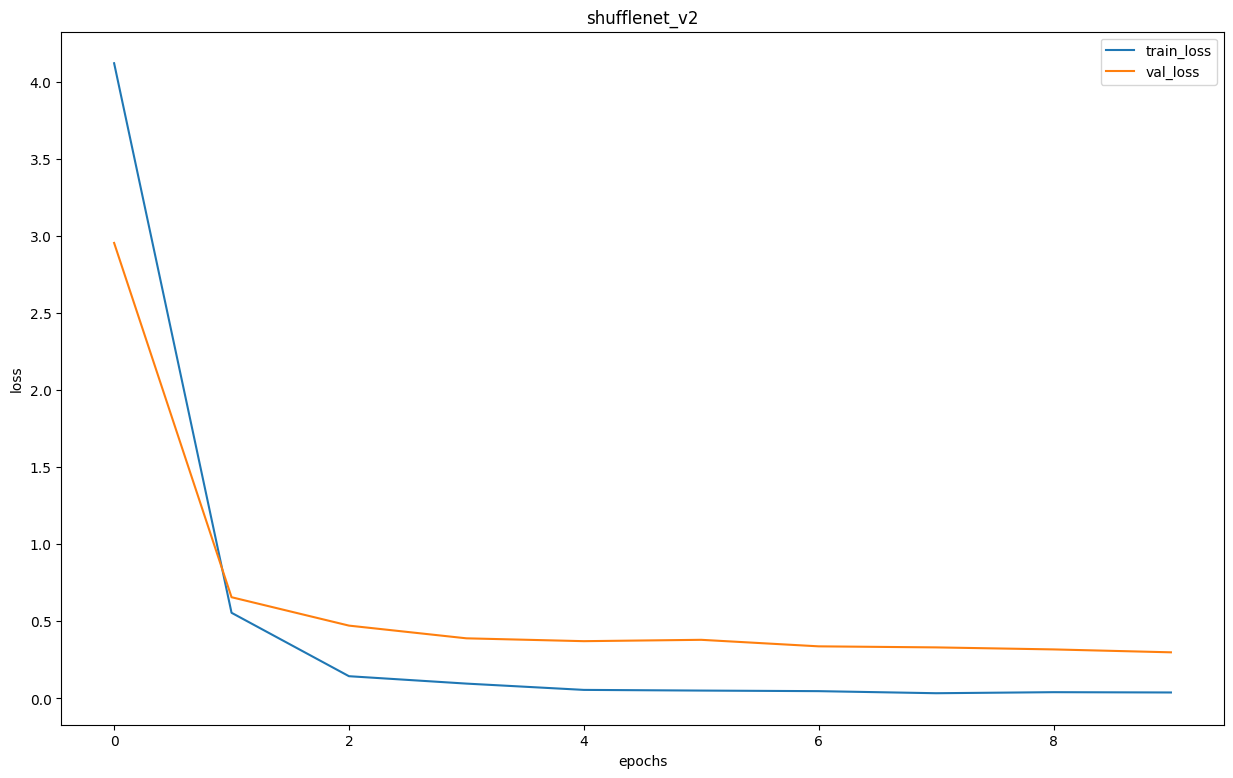

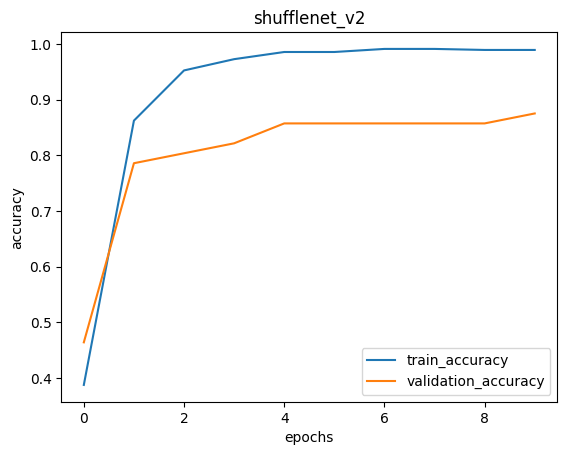

In [41]:
vizualize(history, 'shufflenet_v2')

**Выводы:**
1. ResNet18 и ResNet34 хорошо справляются с поставленной задачей (acc>0.98)
1. MobileNet V3 тоже даёт вполне неплохой результат (acc=0.96), однако она обучается дольше и 10 эпох не хватает, чтобы достигнуть результата ResNet
1. ShuffleNet V2 в данной задаче показывает результат сильно хуже (acc=0.88)
1. В качестве основной модели выберем ResNet34, т.к. по значению функции потерь и точности она лучше остальных, требований на скорость работы и тяжеловесности модели не было.
1. Так как значение функции потерь близко к 0, то дальнейшие эксперименты проводить смысла нет.

# Тестирование

In [42]:
model = resnet34

In [43]:
train_transformer = transforms.Compose([
    transforms.RandomAffine(degrees=5),
    transforms.RandomPerspective(distortion_scale=0.1),
    models.ResNet34_Weights.IMAGENET1K_V1.transforms()
    ])

val_transformer = models.ResNet34_Weights.IMAGENET1K_V1.transforms()

test_transformer = models.ResNet34_Weights.IMAGENET1K_V1.transforms()

In [44]:
train_dataset, val_dataset, test_dataset = gen_datasets(train_transformer, val_transformer, test_transformer)
len(train_dataset), len(val_dataset), len(test_dataset)

(560, 56, 76)

In [45]:
gen = torch.Generator().manual_seed(RANDOM_STATE)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, drop_last=True, generator=gen)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [46]:
result = predict(model, test_dataloader)
print(f'Test Accuracy for resnet34 --> {result[3]:.3}')

Test Accuracy for resnet34 --> 1.0


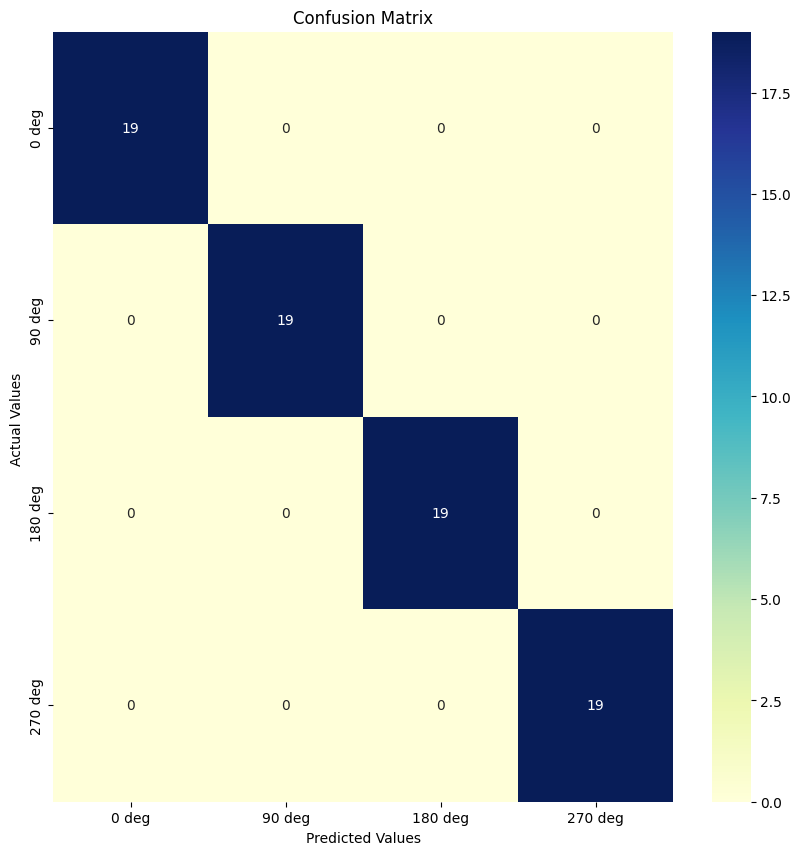

In [47]:
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([f"{i*90} deg" for i in range(4)])
ax.yaxis.set_ticklabels([f"{i*90} deg" for i in range(4)])
plt.show()

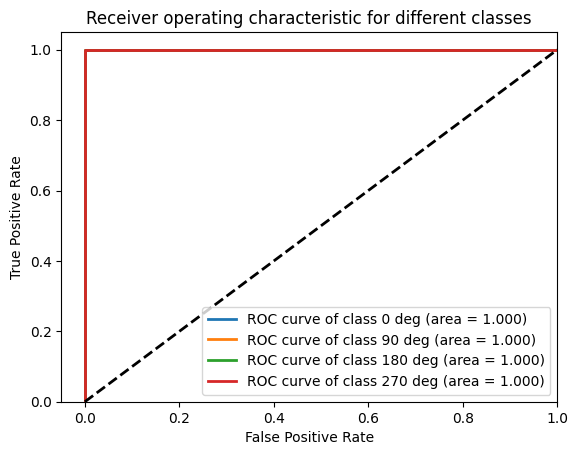

In [48]:
label_test = label_binarize(result[0], classes=range(4))
y_score = result[2]

for i in range(4):
    fpr, tpr, _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2,
             label=f'ROC curve of class {i*90} deg (area = {roc_auc:0.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes')
plt.legend(loc="lower right")
plt.show()

На тесте модель также показывает хорошие результаты, поэтому сохраним её

## Сохранение лучшей модели

In [49]:
torch.save(model.state_dict(), "service/src/resnet_state_dict.pt")